<a href="https://colab.research.google.com/github/alexGood-stack/1/blob/master/_13_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Инфо по выделенным ресурсам


In [1]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install -q gputil
!pip install -q psutil
!pip install -q humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
process = psutil.Process(os.getpid())
print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
print("GPU Model: ", gpu.name)

  Preparing metadata (setup.py) ... done
Gen RAM Free: 12.4 GB  | Proc size: 98.4 MB
GPU RAM Free: 15101MB | Used: 0MB | Util   0% | Total 15360MB
GPU Model:  Tesla T4


# Генетические алгоритмы для обучения нейронных сетей

*Разбор данного раздела:* https://youtu.be/njAH6ASF0H0?t=389

Чтобы запускать и редактировать код, сохраните копию этого ноутбука себе (File->Save a copy in Drive...). Свою копию вы сможете изменять и запускать.

In [2]:
#Загружаем библиотеки

import pandas as pd # Пандас
import matplotlib.pyplot as plt # Отрисовка графиков
from tensorflow.keras import utils # Для to_categorical
import numpy as np # Numpy
from tensorflow.keras.optimizers import Adam # Оптимизатор
from tensorflow.keras.models import Sequential, Model # Два варианты моделей
from tensorflow.keras.layers import concatenate,Reshape, Input,Conv2DTranspose, Lambda, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM, MaxPooling1D, Activation, GlobalMaxPooling1D, UpSampling1D#Стандартные слои
from tensorflow.keras.losses import MAE
from google.colab import files # Загрузка файлов
from sklearn.preprocessing import StandardScaler, MinMaxScaler # Нормировщики
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator # Для генерации выборки временных рядов
import tensorflow.keras.backend as K
import random as random # Импортируем модель randim
import numpy as np # Импортируем библиотеку numpy
import matplotlib.pyplot as plt # Импортируем модуль pyplot библиотеки matplotlib для построения графиков
from PIL import Image # Импортируем одель Image для обработки изображений
import time
from tensorflow.keras.utils import plot_model
# Статический вывод графики (графики отображаются в той ячейке, в которой используется plt.show())
%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Подбор архитектуры свёрточной сети

#Прогнозирование трафика

*Разбор данного раздела:* https://youtu.be/njAH6ASF0H0?t=542

In [4]:
# Считываем данные с помощью pandas
base_data = pd.read_csv('/content/drive/MyDrive/traff.csv',header=None)

In [5]:
# Выводим пять первых строк
base_data

,0,1
0,1/1/2017,"22,226.00"
1,1/2/2017,"29,593.00"
2,1/3/2017,"31,726.00"
3,1/4/2017,"32,684.00"
4,1/5/2017,"31,820.00"
...,...,...
1090,12/27/2019,"29,801.00"
1091,12/28/2019,"34,913.00"
1092,12/29/2019,"37,665.00"
1093,12/30/2019,"32,643.00"


In [18]:
data = base_data.iloc[:,1]

In [19]:
# Выводим параметры одного фала
d = data
print(len(d))         # Сколько есть записей
print(len(d.iloc[0])) # Длинна одной строки данных
print(d.iloc[0])      # Пример первой строки данных

1095
9
22,226.00


In [20]:
data = np.array(data) #Превращаем в numpy массив
for i in range(len(data)):
  data[i] = float(data[i].replace(',',''))

**Функция загрузки данных**

In [21]:
#Формируем параметры загрузки данных
xLen = 60     # Анализируем по 300 прошедшим точкам
valLen = 300  # Используем 300 записей для проверки

trainLen = data.shape[0]-valLen # Размер тренировочной выборки

# Делим данные на тренировочную и тестовую выборки
Train,Test = np.reshape(data[:trainLen],(-1,1)), np.reshape(data[trainLen+xLen+2:],(-1,1))

# Масштабируем данные (отдельно для X и Y), чтобы их легче было скормить сетке
Scaler = MinMaxScaler()
Scaler.fit(Train)
Train = Scaler.transform(Train)
Test = Scaler.transform(Test)


# Создаем генератор для обучения
trainDataGen = TimeseriesGenerator(Train, Train,             # в качестве параметров наши выборки
                               length=xLen, sampling_rate=1, # для каждой точки
                               batch_size=20)                # размер batch, который будем скармливать модели

# Создаем аналогичный генератор для валидации при обучении
testDataGen = TimeseriesGenerator(Test, Test,
                               length=xLen, sampling_rate=1,
                               batch_size=20)

**Функции для отображения результатов**

In [22]:
# Функция рассчитываем результаты прогнозирования сети
# В аргументы принимает сеть (currModel) и проверочную выборку
# Выдаёт результаты предсказания predVal
# И правильные ответы в исходной размерности yValUnscaled (какими они были до нормирования)
def getPred(currModel, xVal, yVal, yScaler):
  # Предсказываем ответ сети по проверочной выборке
  # И возвращаем исходны масштаб данных, до нормализации
  predVal = yScaler.inverse_transform(currModel.predict(xVal))
  yValUnscaled = yScaler.inverse_transform(yVal)

  return (predVal, yValUnscaled)

# Функция визуализирует графики, что предсказала сеть и какие были правильные ответы
# start - точка с которой начинаем отрисовку графика
# step - длина графика, которую отрисовываем
# channel - какой канал отрисовываем
def showPredict(start, step, channel, predVal, yValUnscaled):
  plt.plot(predVal[start:start+step, channel],
           label='Прогноз')
  plt.plot(yValUnscaled[start:start+step, channel],
           label='Базовый ряд')
  plt.xlabel('Время')
  plt.ylabel('Значение Close')
  plt.legend()
  plt.show()

# Функция расёта корреляции дух одномерных векторов
def correlate(a, b):
  # Рассчитываем основные показатели
  ma = a.mean() # Среднее значение первого вектора
  mb = b.mean() # Среднее значение второго вектора
  mab = (a*b).mean() # Среднее значение произведения векторов
  sa = a.std() # Среднеквадратичное отклонение первого вектора
  sb = b.std() # Среднеквадратичное отклонение второго вектора

  #Рассчитываем корреляцию
  val = 0
  if ((sa>0) & (sb>0)):
    val = (mab-ma*mb)/(sa*sb)
  return val

# Функция рисуем корреляцию прогнозированного сигнала с правильным
# Смещая на различное количество шагов назад
# Для проверки появления эффекта автокорреляции
# channels - по каким каналам отображать корреляцию
# corrSteps - на какое количество шагов смещать сигнал назад для рассчёта корреляции
# showGraf - показываем график или нет
# returnData - возвращаем массивы автокорреляции или нет
def autoCorr(channels, corrSteps, predVal, yValUnscaled, showGraf = True, returnData = False):
  # Проходим по всем каналам
  for ch in channels:
    corr = [] # Создаём пустой лист, в нём будут корреляции при смезении на i рагов обратно
    yLen = yValUnscaled.shape[0] # Запоминаем размер проверочной выборки

      # Постепенно увеличикаем шаг, насколько смещаем сигнал для проверки автокорреляции
    for i in range(corrSteps):
      # Получаем сигнал, смещённый на i шагов назад
      # predVal[i:, ch]
      # Сравниваем его с верными ответами, без смещения назад
      # yValUnscaled[:yLen-i,ch]
      # Рассчитываем их корреляцию и добавляем в лист
      corr.append(correlate(yValUnscaled[:yLen-i,ch], predVal[i:, ch]))

    own_corr = [] # Создаём пустой лист, в нём будут корреляции при смезении на i рагов обратно

      # Постепенно увеличикаем шаг, насколько смещаем сигнал для проверки автокорреляции
    for i in range(corrSteps):
      # Получаем сигнал, смещённый на i шагов назад
      # predVal[i:, ch]
      # Сравниваем его с верными ответами, без смещения назад
      # yValUnscaled[:yLen-i,ch]
      # Рассчитываем их корреляцию и добавляем в лист
      own_corr.append(correlate(yValUnscaled[:yLen-i,ch], yValUnscaled[i:, ch]))

    # Отображаем график коррелций для данного шага
    if showGraf: #Если нужно показать график
      plt.plot(corr, label='предсказание на ' + str(ch+1) + ' шаг')
      plt.plot(own_corr, label='Эталон')

  if showGraf: #Если нужно показать график
    plt.xlabel('Время')
    plt.ylabel('Значение')
    plt.legend()
    plt.show()

  if returnData: #Если нужно вернуть массивы автокорреляции
    return corr, own_corr

**Генерируем проверочную выборку**

In [23]:
# Создадим генератор проверочной выборки, из которой потом вытащим xVal, yVal для проверки
DataGen = TimeseriesGenerator(Test, Test,
                               length=xLen, sampling_rate=1,
                               batch_size=len(Test)) # Размер batch будет равен длине нашей выборки

xVal = []
yVal = []
for i in DataGen:
  xVal.append(i[0])
  yVal.append(i[1])

xVal = np.array(xVal)
yVal = np.array(yVal)

# Подбор линейной архитектуры

*Разбор данного раздела:* https://youtu.be/njAH6ASF0H0?t=706

**Входной слой**

*   0 - делаем ли нормализацию
*   1 - размер первого свёрточного слоя
*   2 - ядро первого свёрточного слоя
*   3 - функция активации первого слоя
*   4 - делаем ли MaxPooling0
*   5 - размер MaxPooling0

**Первый скрытый слой**

*   6 - Делаем ли второй сверточный слой
*   7 - размер второго сверточного слоя
*   8 - ядро второго сверточного слоя
*   9 - делаем ли MaxPooling1
*   10 - размер MaxPooling1
*   11 - функция активации

**Второй скрытый слой**

*   12 - Делаем ли третий сверточный слой
*   13 - размер третьего сверточного слоя
*   14 - ядро третьего сверточного слоя
*   15 - делаем ли MaxPooling2
*   16 - размер MaxPooling2
*   17 - функция активации
----
*   18 - функция активации предпоследнего слоя
*   19 - функция активации выходного слоя
----
**Третий(предпоследний) скрытый слой**

*   20 - делаем ли нормализацию
*   21 - размер полносвязного слоя

In [13]:
#Создаём сеть (net - список параметров)
def createConvNet(net):

  model = Sequential()             # Создаем моель Sequential

  makeFirstNormalization = net[0]  # Делаем ли нормализацию в начале
  firstConvSize = 2 ** net[1]      # Размер первого вёрточного слоя
  firstConvKernel = net[2]         # Ядро первого свёрточного слоя
  activation0 = net[3]             # Функция активации входного слоя
  makeMaxPooling0 = net[4]         # Делаем ли maxpooling для нулевого слоя
  maxPoolingSize0 = net[5]         # Размер MaxPooling

  makeSecondConv = net[6]          # Делаем ли второй свёрточный слой
  secondConvSize = 2 ** net[7]     # Размер второго свёрточного слоя
  secondConvKernel = net[8]        # Ядро второго свёрточного слоя
  makeMaxPooling1 = net[9]         # Делаем ли MaxPooling
  maxPoolingSize1 = net[10]        # Размер MaxPooling
  activation1 = net[11]            # Функция активации

  makeThirdConv = net[12]          # Делаем ли второй свёрточный слой
  thirdConvSize = 2 ** net[13]     # Размер второго свёрточного слоя
  thirdConvKernel = net[14]        # Ядро второго свёрточного слоя
  makeMaxPooling2 = net[15]        # Делаем ли MaxPooling
  maxPoolingSize2 = net[16]        # Размер MaxPooling
  activation2 = net[17]            # Функция активации

  activation3 = net[18]            # Функция активации для
  activation4 = net[19]            # Функция активации для последнего слоя

  makeSecondNormalization = net[20] # Делаем ли финальную нормализацию
  denseSize = 2 ** net[21]          # Размер полносвязного слоя

  activation_list = ['linear','relu','tanh','softmax','sigmoid']

  if (makeFirstNormalization):      # Если делаем нормализацию в начале

    # Добавляем слой BatchNormalization
    model.add(BatchNormalization(input_shape=(xLen, 1)))

    # Добавляем Conv1D-слой с firstConvSize нейронами и ядром (firstConvKernel)
    model.add(Conv1D(firstConvSize, firstConvKernel, activation=activation_list[activation0], padding='same'))
  else:

    # Добавляем Conv1D-слой с firstConvSize нейронами и ядром (firstConvKernel)
    model.add(Conv1D(firstConvSize, firstConvKernel, input_shape=(xLen, 1), activation=activation_list[activation0], padding='same'))

  if makeMaxPooling0:               # Если делаем maxpooling
    model.add(MaxPooling1D(maxPoolingSize0))


  if (makeSecondConv):              # Если делаем второй свёрточный слой
    # Добавляем Conv1D-слой с secondConvSize нейронами и ядром (secondConvKernel)
    model.add(Conv1D(secondConvSize, secondConvKernel, activation=activation_list[activation1], padding='same'))

    if (makeMaxPooling1):           # Если делаем MaxPooling
      # Добавляем слой MaxPooling1D с размером (maxPoolingSize)
      model.add(MaxPooling1D(pool_size=maxPoolingSize1))


  if (makeThirdConv):               # Если делаем второй свёрточный слой
    # Добавляем Conv1D-слой с secondConvSize нейронами и ядром (secondConvKernel)
    model.add(Conv1D(thirdConvSize, thirdConvKernel, activation=activation_list[activation2], padding='same'))

    if (makeMaxPooling2):           # Если делаем MaxPooling
      # Добавляем слой MaxPooling1D с размером (maxPoolingSize, maxPoolingSize)
      model.add(MaxPooling1D(pool_size=maxPoolingSize2))

  if (makeSecondNormalization):     # Если делаем финальную нормализацию
    model.add(BatchNormalization()) # Добавляем слой BatchNormalization

  model.add(Flatten())              # Добавляем слой Flatten

  model.add(Dense(denseSize, activation=activation_list[activation3])) # Добавляем слой Dense с denseSize нейронами
  model.add(Dense(1, activation=activation_list[activation4]))         # Добавляем Dense-слой с softmax-активацией и 10 нейронами

  return model                      # Возвращаем модель

'''
  Функция вычисления результата работы сети
'''

def evaluateNet(net, ep, verb):
  val = 0
  time.time()
  model = createConvNet(net) # Создаем модель createConvNet

  # Компилируем модель
  model.compile(optimizer=Adam(lr=1e-4),
                  loss='mse')

  history = model.fit_generator(trainDataGen,
                    epochs=5,
                    verbose=verb,
                    validation_data=testDataGen)

  val = history.history["val_loss"][-1] # Возвращаем точность на проверочной выборке с последней эпохи

  return val, model                      # Возвращаем точность

'''
  Функция создания списка случайных параметров
'''
def createRandomNet():
  net = []
  net.append(random.randint(0,1)) #Делаем или нет нормализацию
  net.append(random.randint(3,6)) #Первый свёрточный слой от 8 до 64 нейронов
  net.append(random.randint(3,7)) #Ядро первого свёрточного слоя от 3 до 7
  net.append(random.randint(0,4)) # Функция активации первого слоя
  net.append(random.randint(0,1)) #Делаем ли MaxPooling
  net.append(random.randint(2,3)) #Размер MaxPooling

  net.append(random.randint(0,1)) # Сколько делаем еще сверточных слоев
  net.append(random.randint(3,6)) # Второй свёрточный слой от 8 до 64 нейронов
  net.append(random.randint(3,7)) # Ядро второго свёрточного слоя от 3 до 7
  net.append(random.randint(0,1)) # Делаем ли MaxPooling
  net.append(random.randint(2,3)) # Размер MaxPooling
  net.append(random.randint(0,4)) # Функция активации второго слоя

  net.append(random.randint(0,1)) # Сколько делаем еще сверточных слоев
  net.append(random.randint(3,6)) # Второй свёрточный слой от 8 до 64 нейронов
  net.append(random.randint(3,7)) # Ядро второго свёрточного слоя от 3 до 7
  net.append(random.randint(0,1)) # Делаем ли MaxPooling
  net.append(random.randint(2,3)) # Размер MaxPooling
  net.append(random.randint(0,4)) # Функция активации второго слоя

  net.append(random.randint(0,4)) # Функция активации предпоследнего dense слоя
  net.append(random.randint(0,2)) # Функция активации последнего слоя

  net.append(random.randint(0,1)) # Делаем ли финальную нормализацию слой
  net.append(random.randint(3,6)) # Размер полносвязного слоя от 8 до 64

  return net

In [14]:
n = 20              # Общее число ботов
nsurv = 10          # Количество выживших (столько лучших переходит в новую популяцию)
nnew = n - nsurv    # Количество новых (столько новых ботов создается)
l = 22              # Размер бота
epohs = 10          # количество эпох

mut = 0.09          # коэфициент мутаций

popul = []          # Массив популяции
val = []            # Одномерный массив значений этих ботов

#Создаём случайных ботов
for i in range(n):
  popul.append(createRandomNet())

for it in range(epohs):                 # Пробегаем по всем эпохам
  val = []                              # Обнуляем значения бота
  curr_time = time.time()
  for i in range(n):                    # Пробегаем в цикле по всем ботам
    bot = popul[i]                      # Берем очередного бота
    f, model_sum = evaluateNet(bot, 3, 0) # Вычисляем точность текущего бота
    val.append(f)                       # Добавляем полученное значение в список val

  sval = sorted(val, reverse=0)         # Сортируем val
  # Выводим 5 лучших ботов
  print(it, time.time() - curr_time, " ", sval[0:5],popul[:5])

  newpopul = []                         # Создаем пустой список под новую популяцию
  for i in range(nsurv):                # Пробегаем по всем выжившим ботам
    index = val.index(sval[i])          # Получаем индекс очередного бота из списка лучших в списке val
    newpopul.append(popul[index])       # Добавляем в новую популяцию бота из popul с индексом index

  for i in range(nnew):                 # Проходимся в цикле nnew-раз
    indexp1 = random.randint(0,nsurv-1) # Случайный индекс первого родителя в диапазоне от 0 до nsurv - 1
    indexp2 = random.randint(0,nsurv-1) # Случайный индекс первого родителя в диапазоне от 0 до nsurv - 1
    botp1 = newpopul[indexp1]           # Получаем первого бота-родителя по indexp1
    botp2 = newpopul[indexp2]           # Получаем второго бота-родителя по indexp2
    newbot = []                         # Создаем пустой список под значения нового бота
    net4Mut = createRandomNet()         # Создаем случайную сеть для мутаций
    for j in range(l):                  # Пробегаем по всей длине бота
      x = 0
      pindex = random.random()          # Получаем случайное число в диапазоне от 0 до 1

      # Если pindex меньше 0.5, то берем значения от первого бота, иначе от второго
      if pindex < 0.5:
        x = botp1[j]
      else:
        x = botp2[j]

      # С вероятностью mut устанавливаем значение бота из net4Mut
      if (random.random() < mut):
        x = net4Mut[j]

      newbot.append(x)                  # Добавляем очередное значение в нового бота
    newpopul.append(newbot)             # Добавляем бота в новую популяцию
  popul = newpopul                      # Записываем в popul новую посчитанную популяцию

NameError: ignored

In [ ]:
print(popul) #Геномы лучших ботов по эпохам

[[0, 6, 3, 1, 0, 3, 1, 4, 3, 0, 3, 2, 0, 3, 3, 0, 3, 4, 1, 0, 0, 5], [0, 6, 7, 1, 0, 2, 1, 4, 6, 0, 3, 2, 0, 3, 3, 1, 3, 3, 1, 0, 0, 4], [0, 5, 7, 2, 0, 3, 1, 3, 3, 0, 3, 2, 0, 6, 3, 0, 3, 4, 1, 0, 0, 5], [0, 6, 7, 1, 0, 3, 1, 4, 7, 0, 3, 2, 0, 3, 3, 1, 3, 3, 2, 0, 0, 5], [0, 5, 7, 1, 0, 3, 1, 3, 7, 0, 3, 2, 0, 5, 3, 0, 3, 4, 1, 0, 0, 5], [0, 6, 3, 2, 0, 2, 1, 4, 3, 0, 3, 2, 0, 3, 3, 0, 3, 4, 1, 1, 0, 5], [0, 6, 6, 1, 0, 2, 1, 5, 3, 0, 2, 1, 0, 4, 4, 0, 3, 4, 1, 0, 0, 4], [0, 6, 6, 2, 0, 3, 1, 3, 7, 1, 3, 2, 0, 5, 3, 0, 3, 4, 1, 0, 0, 5], [0, 6, 6, 2, 0, 2, 1, 3, 3, 1, 3, 2, 0, 5, 3, 0, 3, 4, 1, 0, 0, 5], [0, 6, 7, 2, 0, 3, 1, 3, 3, 1, 3, 2, 0, 3, 3, 0, 3, 4, 1, 0, 0, 5], [0, 6, 6, 2, 0, 3, 1, 4, 7, 1, 3, 2, 0, 3, 3, 0, 3, 4, 1, 0, 1, 5], [0, 6, 3, 1, 0, 2, 1, 4, 7, 0, 3, 2, 0, 3, 3, 1, 3, 4, 2, 0, 0, 5], [0, 6, 7, 1, 0, 3, 1, 3, 3, 1, 3, 2, 0, 5, 3, 0, 3, 4, 1, 0, 0, 5], [0, 5, 7, 2, 0, 3, 1, 3, 3, 1, 3, 2, 0, 5, 3, 0, 3, 4, 1, 0, 0, 5], [0, 6, 6, 1, 0, 3, 1, 5, 3, 1, 2, 1, 1, 4, 4, 0

In [ ]:
model = createConvNet(popul[0])
model.summary()


Model: "sequential_200"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_418 (Conv1D)         (None, 60, 64)            256       
                                                                 
 conv1d_419 (Conv1D)         (None, 60, 16)            3088      
                                                                 
 flatten_200 (Flatten)       (None, 960)               0         
                                                                 
 dense_400 (Dense)           (None, 32)                30752     
                                                                 
 dense_401 (Dense)           (None, 1)                 33        
                                                                 
Total params: 34,129
Trainable params: 34,129
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Комипилируем и обучаем
model.compile(optimizer=Adam(lr=1e-4),
                loss='mse')

history = model.fit_generator(trainDataGen,
                    epochs=50,
                    validation_data=testDataGen)

Epoch 1/50


<ipython-input-16-34e20ecd72f2>:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(trainDataGen,


37/37 [==============================] - 2s 9ms/step - loss: 0.0381 - val_loss: 0.0176
Epoch 2/50
37/37 [==============================] - 0s 6ms/step - loss: 0.0130 - val_loss: 0.0213
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.0108 - val_loss: 0.0132
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.0077 - val_loss: 0.0063
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.0065 - val_loss: 0.0058
Epoch 6/50
37/37 [==============================] - 0s 6ms/step - loss: 0.0055 - val_loss: 0.0104
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.0045 - val_loss: 0.0048
Epoch 8/50
37/37 [==============================] - 0s 5ms/step - loss: 0.0055 - val_loss: 0.0125
Epoch 9/50
37/37 [==============================] - 0s 5ms/step - loss: 0.0048 - val_loss: 0.0050
Epoch 10/50
37/37 [==============================] - 0s 6ms/step - loss: 0.0041 - val_loss: 0.0044
Epoch 11/50
37/37 [===========

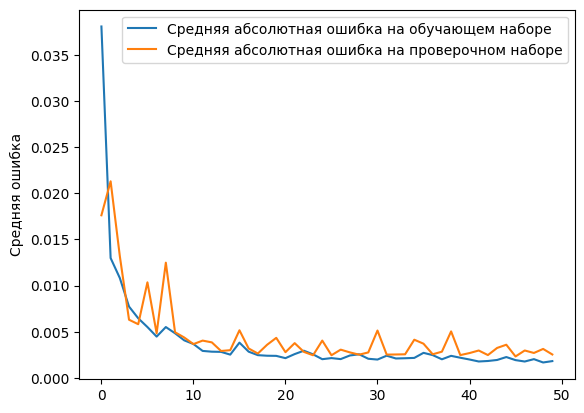

In [ ]:
plt.plot(history.history['loss'],
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'],
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

6/6 [==============================] - 0s 2ms/step


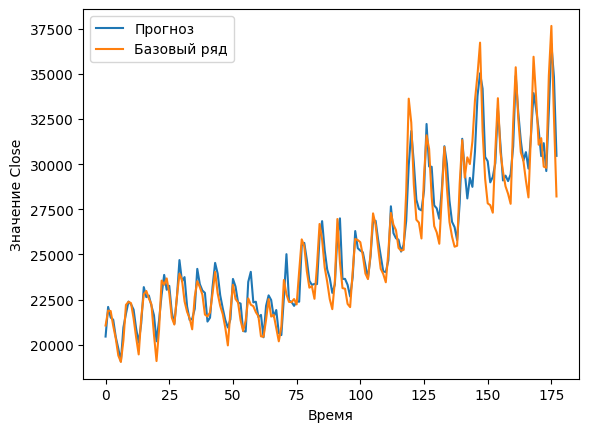

In [ ]:
# Прогнозируем данные текущей сетью
currModel = model #Выбираем текущую модель
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], Scaler) #Прогнозируем данные

# Отображаем графики
showPredict(0, 400, 0, predVal, yValUnscaled)

In [12]:
# Отображаем корреляцию
# Используем выходной канал - только open
# Проверяем корреляцию на глубину 60 шагов
autoCorr([0], 20, predVal, yValUnscaled)

NameError: ignored

# Пример "человеческой сборки" нелинейной

*Разбор данного раздела:* https://youtu.be/njAH6ASF0H0?t=1858




In [11]:
# Отображаем корреляцию
# Используем выходной канал - только open
# Проверяем корреляцию на глубину shape = (xLen, 1)
shape = (xLen, 1)

inputs = Input(shape)
list_to_concat = [inputs]

x = BatchNormalization()(inputs)
maxPoolingSize = 3

x = Conv1D(2**6,3,padding='same')(x)
x = Activation('linear')(x)
list_to_concat.append(x)

x = Conv1D(2**6,5,padding='same')(x)
x = Activation('tanh')(x)
list_to_concat.append(x)

x = Conv1D(2**8,5,padding='same')(x)
x = Activation('linear')(x)
list_to_concat.append(x)

for i in range(len(list_to_concat)):
  list_to_concat[i]=Flatten()(list_to_concat[i])

fin = concatenate(list_to_concat)
fin = Dense(2**6)(fin)
fin = Activation('linear')(fin)

fin = Dense(1)(fin)

modelC = Model(inputs, fin)

modelC.compile(loss="mse", optimizer=Adam(lr=1e-4))

history = modelC.fit_generator(trainDataGen,
                    epochs=50,
                    verbose=1,
                    validation_data=testDataGen)

plt.plot(history.history['loss'],
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'],
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

NameError: ignored

In [10]:
# Прогнозируем данные текущей сетью
currModel = modelC #Выбираем текущую модель
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], Scaler) #Прогнозируем данные

# Отображаем графики
showPredict(0, 400, 0, predVal, yValUnscaled)

NameError: ignored

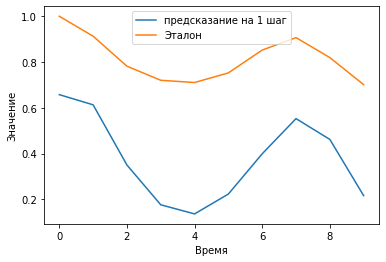

In [ ]:
# Отображаем корреляцию
# Используем выходной канал - только open
# Проверяем корреляцию на глубину 60 шагов
autoCorr([0], 10, predVal, yValUnscaled)

# Подбор нелинейной архитектуры

*Разбор данного раздела:* https://youtu.be/njAH6ASF0H0?t=2060



**БЛОК 1**
*   0 - делаем ли нормализацию
*   1 - размер MaxPooling для всех слоев

*   2 - размер первого свёрточного слоя
*   3 - ядро первого свёрточного слоя
*   4 - функция активации первого слоя

**БЛОК 2**
*   5 - делаем ли второй свёрточный слой
*   6 - размер второго свёрточного слоя
*   7 - ядро второго свёрточного слоя
*   8 - делаем ли MaxPooling
*   9 - функция активации второго слоя

**БЛОК 3**
*   10 - делаем ли второй свёрточный слой
*   11 - размер второго свёрточного слоя
*   12 - ядро второго свёрточного слоя
*   13 - делаем ли MaxPooling
*   14 - функция активации второго слоя

**БЛОК 4**
*   15 - делаем ли второй свёрточный слой
*   16 - размер второго свёрточного слоя
*   17 - ядро второго свёрточного слоя
*   18 - делаем ли MaxPooling
*   19 - функция активации второго слоя

**БЛОК 5**
*   20 - делаем ли второй свёрточный слой
*   21 - размер второго свёрточного слоя
*   22 - ядро второго свёрточного слоя
*   23 - делаем ли MaxPooling
*   24 - функция активации второго слоя

**БЛОК 6**
*   25 - делаем ли нормализацию перед полносвязным слоем
*   26 - делаем ли полносвязный слой
*   27 - размер полносвязного слоя

In [1]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install -q gputil
!pip install -q psutil
!pip install -q humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
process = psutil.Process(os.getpid())
print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
print("GPU Model: ", gpu.name)
#Создаём сеть (net - список параметров)
def createConvNet(net):

  makeFirstNormalization = net[0] # Делаем ли нормализацию в начале
  maxPoolKernel = net[1]          # Ядро пуллинга

  firstConvSize = 2 ** net[2]     # Размер первого cвёрточного слоя
  firstConvKernel = net[3]        # Ядро первого свёрточного слоя
  activation1 = net[4]            # Функция активации первого слоя

  makeConv2 = net[5]              # Делаем ли второй сверточный слой
  secondConvSize = 2 ** net[6]    # Ядро второго свёрточного слоя
  secondConvKernel = net[7]       # Размер второго свёрточного слоя
  makePool2 = net[8]              # Делаем ли пуллинг?
  activation2 = net[9]            # Функция активации второго слоя

  makeConv3 = net[10]             # Делаем ли  сверточный слой
  thirdConvSize = 2 ** net[11]    # Ядро третьего свёрточного слоя
  thirdConvKernel = net[12]       # Размер третьего свёрточного слоя
  makePool3 = net[13]             # Делаем ли пуллинг?
  activation3 = net[14]           # Функция активации третьего слоя

  makeConv4 = net[15]             # Делаем ли  сверточный слой
  fourthConvSize = 2 ** net[16]   # Ядро четвертого свёрточного слоя
  fourthConvKernel = net[17]      # Размер четвертого свёрточного слоя
  makePool4 = net[18]             # Делаем ли пуллинг?
  activation4 = net[19]           # Функция активации четвертого слоя

  makeConv5 = net[20]             # Делаем ли  сверточный слой
  fifthConvSize = 2 ** net[21]    #  Ядро пятого свёрточного слоя
  fifthConvKernel = net[22]       # Размер пятого свёрточного слоя
  makePool5 = net[23]             # Делаем ли пуллинг?
  activation5 = net[24]           # Функция активации пятого слоя


  makeDense = net[25]             # Делаем ли полносвязный
  denseSize = 2 ** net[26]        # Размер полносвязного слоя
  activation6 = net[27]           # Фукнция активации пятго слоя

  shape = (xLen, 1)               # Размер входных данных
  inputs = Input(shape)           # Входной слой

  # Список активационных функций
  activation_list = ['linear','relu','tanh','softmax','sigmoid']

  if (makeFirstNormalization):    # Если делаем нормализацию в начале
    x = BatchNormalization()(inputs)
    x = Conv1D(firstConvSize,firstConvKernel, padding ='same')(x)
    x = Activation(activation_list[activation1])(x)

  else:                           # Если не делаем нормализацию в начале
    x = Conv1D(firstConvSize,firstConvKernel, padding ='same')(inputs)
    x = Activation(activation_list[activation1])(x)

  list_to_concat = [inputs]       # Этот список будем потом склеивать

  for i in range(4):              # Проходимся по каждому блоку
    if net[5+5*i]!=0:             # Добавление блока
      x = Conv1D(net[6+5*i],net[7+5*i], padding ='same')(x)
      x = Activation(activation_list[net[5*i+4]])(x)
      x = Reshape((-1,1))(x)

      if net[8+5*i]!=0:           # Добавление пулинга
        x = MaxPooling1D(maxPoolKernel)(x)
        list_to_concat.append(x)  # Добавляем в список
      #  print(x)
      else:
        list_to_concat.append(x)  # Иначе сразу добавляем в список

      list_to_concat.append(x)    # Добавляем в список

  # Проходим по всем значениям списка list_to_concat и делаем flatten
  for i in range(len(list_to_concat)):
    if list_to_concat[i].shape != (None,0,1):
      list_to_concat[i] = Flatten()(list_to_concat[i])
    else:
      break

  # Соединяем значения списка в единое целое
  if len(list_to_concat) != 1:
     fin = concatenate(list_to_concat)

  # Иначе просто делаем flatten
  else:
    fin = x
    fin = Flatten()(fin)

  # Добавление полносвязного слоя
  if makeDense!=0:
    fin = Dense(denseSize)(fin)
    fin = Activation(activation_list[activation6])(fin)

  fin = Dense(1)(fin)

  model = Model(inputs, fin)  # Создаем моель Sequential
  return model                # Возвращаем моель

'''
  Функция вычисления резульата работы сети
'''
def evaluateNet(net, ep, verb):
  val = 0
  model = createConvNet(net)  # Создаем модель createConvNet
  # Компилируем модель
  model.compile(optimizer=Adam(lr=1e-4),
                  loss='mse')

  history = model.fit_generator(trainDataGen,
                    epochs=5,
                    verbose=verb,
                    validation_data=testDataGen)
  # Прогнозируем данные текущей сетью
  (predVal, yValUnscaled) = getPred(model, xVal[0], yVal[0], Scaler) #Прогнозируем данные

  # Возвращаем автокорреляцию
  corr, own_corr = autoCorr([0], 5, predVal, yValUnscaled, showGraf = False, returnData = True)
  val = MAE(corr, own_corr).numpy() + history.history["val_loss"][-1] #Считаем MAE и прибавляем ошибку

  return val, model # Возвращаем точность

'''
  Функция создания списка случайных параметров
'''
def createRandomNet():
  net = []
  net.append(random.randint(0,1)) # Делаем или нет нормализацию
  net.append(random.randint(2,4)) # Ядро maxPooling

  net.append(random.randint(3,10)) # Первый свёрточный слой от 8 до 1024 нейронов
  net.append(random.randint(3,7))  # Ядро первого свёрточного слоя от 3 до 7
  net.append(random.randint(0,4))  # Функция активации


  net.append(random.randint(0,1))  # Делаем ли второй сверточный
  net.append(random.randint(3,10)) # Второй свёрточный слой от 8 до 1024 нейронов
  net.append(random.randint(3,7))  # Ядро второго свёрточного слоя от 3 до 7
  net.append(random.randint(0,1))  # Делаем ли MaxPooling
  net.append(random.randint(0,4))  # Функция активации

  net.append(random.randint(0,1))  # Делаем ли третий сверточный
  net.append(random.randint(3,10)) # Третий свёрточный слой от 8 до 1024 нейронов
  net.append(random.randint(3,7))  # Ядро третьего свёрточного слоя от 3 до 7
  net.append(random.randint(0,1))  # Делаем ли MaxPooling
  net.append(random.randint(0,4))  # Функция активации

  net.append(random.randint(0,1))  # Делаем ли четвертый сверточный
  net.append(random.randint(3,10)) # Четвертый свёрточный слой от 8 до 1024 нейронов
  net.append(random.randint(3,7))  # Ядро четвертого свёрточного слоя от 3 до 7
  net.append(random.randint(0,1))  # Делаем ли MaxPooling
  net.append(random.randint(0,4))  # Функция активации

  net.append(random.randint(0,1))  # Делаем ли пятый сверточный
  net.append(random.randint(3,10)) # Пятый свёрточный слой от 8 до 1024 нейронов
  net.append(random.randint(3,7))  # Ядро пятого свёрточного слоя от 3 до 7
  net.append(random.randint(0,1))  # Делаем ли MaxPooling
  net.append(random.randint(0,4))  # Функция активации

  net.append(random.randint(0,1))  # Делаем ли полносвязный слой
  net.append(random.randint(3,10)) # Размер полносвязного слоя от 8 до 1024
  net.append(random.randint(0,4))  # Функция активации
  return net

In [2]:
n = 20                    # Общее число ботов
nsurv = 7                 # Количество выживших (столько лучших переходит в новую популяцию)
nnew = n - nsurv          # Количество новых (столько новых ботов создается)
l = 28                    # Размер бота
epohs = 9                 # количество эпох
mut = 0.4                 # коэфициент мутаций

popul = []                # Массив популяции
val = []                  # Одномерный массив значений этих ботов

#Создаём случайных ботов
for i in range(n):
  popul.append(createRandomNet())

for it in range(epohs):   # Пробегаем по всем эпохам
  val = []                # Обнуляем значения бота
  curr_time = time.time()
  for i in range(n):      # Пробегаем в цикле по всем ботам
    bot = popul[i]        # Берем очередного бота

    # Вычисляем точность текущего бота
    f,model_sum = evaluateNet(bot, 3, 0)
    val.append(f)         # Добавляем полученное значение в список val

  # Сортируем val
  sval = sorted(val, reverse=0)

  # Выводим 5 лучших ботов
  print(it, time.time() - curr_time,  " ", sval[0:5],popul[:5])

  newpopul = []                         # Создаем пустой список под новую популяцию
  for i in range(nsurv):                # Пробегаем по всем выжившим ботам
    index = val.index(sval[i])          # Получаем индекс очередного бота из списка лучших в списке val
    newpopul.append(popul[index])       # Добавляем в новую популяцию бота из popul с индексом index

  for i in range(nnew):                 # Проходимся в цикле nnew-раз
    indexp1 = random.randint(0,nsurv-1) # Случайный индекс первого родителя в диапазоне от 0 до nsurv - 1
    indexp2 = random.randint(0,nsurv-1) # Случайный индекс первого родителя в диапазоне от 0 до nsurv - 1
    botp1 = newpopul[indexp1]           # Получаем первого бота-родителя по indexp1
    botp2 = newpopul[indexp2]           # Получаем второго бота-родителя по indexp2
    newbot = []                         # Создаем пустой список под значения нового бота
    net4Mut = createRandomNet()         # Создаем случайную сеть для мутаций
    for j in range(l):                  # Пробегаем по всей длине размерности (784)
      x = 0
      pindex = random.random()          # Получаем случайное число в диапазоне от 0 до 1

      # Если pindex меньше 0.5, то берем значения от первого бота, иначе от второго
      if pindex < 0.5:
        x = botp1[j]
      else:
        x = botp2[j]

      # С вероятностью mut устанавливаем значение бота из net4Mut
      if (random.random() < mut):
        x = net4Mut[j]

      newbot.append(x)                  # Добавляем очередное значение в нового бота
    newpopul.append(newbot)             # Добавляем бота в новую популяцию
  popul = newpopul                      # Записываем в popul новую посчитанную популяцию

NameError: ignored

## Проверка результатов

*Разбор данного раздела:* https://youtu.be/njAH6ASF0H0?t=2746


In [26]:
print(popul) #Геномы лучших ботов по эпохам

[[0, 2, 3, 6, 2, 0, 6, 4, 0, 1, 0, 9, 4, 0, 1, 1, 10, 6, 1, 1, 1, 8, 5, 0, 3, 0, 7, 1], [0, 2, 4, 5, 2, 0, 4, 6, 0, 3, 0, 4, 5, 0, 1, 0, 4, 5, 1, 0, 1, 8, 7, 0, 0, 0, 3, 0], [0, 3, 10, 7, 2, 0, 6, 4, 0, 1, 0, 10, 4, 0, 1, 0, 6, 6, 0, 2, 1, 8, 7, 0, 2, 0, 4, 2], [0, 2, 5, 6, 2, 0, 5, 4, 0, 1, 0, 10, 5, 0, 0, 1, 10, 7, 0, 2, 1, 8, 7, 0, 3, 0, 7, 0], [0, 2, 10, 6, 0, 0, 6, 3, 0, 4, 0, 3, 5, 0, 1, 0, 3, 4, 0, 3, 0, 9, 7, 0, 0, 0, 7, 2], [0, 2, 6, 4, 2, 1, 3, 7, 0, 1, 1, 8, 5, 0, 0, 1, 10, 3, 0, 2, 0, 8, 5, 1, 0, 0, 7, 0], [0, 2, 6, 6, 2, 0, 5, 7, 0, 0, 1, 3, 5, 1, 4, 0, 3, 7, 1, 2, 1, 6, 7, 0, 3, 0, 4, 2], [0, 3, 10, 7, 2, 0, 9, 4, 0, 1, 0, 4, 4, 0, 1, 1, 6, 6, 0, 2, 1, 6, 7, 0, 4, 0, 4, 1], [0, 2, 6, 6, 1, 0, 6, 7, 0, 4, 0, 9, 5, 1, 0, 0, 4, 7, 0, 2, 1, 9, 7, 0, 1, 0, 5, 2], [0, 3, 5, 7, 2, 1, 8, 4, 0, 2, 0, 4, 3, 0, 0, 0, 6, 3, 0, 2, 1, 8, 7, 0, 2, 0, 4, 2], [0, 2, 5, 4, 2, 0, 3, 3, 0, 1, 1, 10, 5, 0, 1, 1, 10, 7, 1, 2, 0, 9, 7, 0, 0, 0, 7, 0], [0, 3, 10, 5, 2, 0, 4, 4, 0, 1, 0, 8, 5, 1,

In [27]:
model = createConvNet(popul[0])
model.summary()

Model: "model_180"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_181 (InputLayer)         [(None, 60, 1)]      0           []                               
                                                                                                  
 conv1d_527 (Conv1D)            (None, 60, 8)        56          ['input_181[0][0]']              
                                                                                                  
 activation_592 (Activation)    (None, 60, 8)        0           ['conv1d_527[0][0]']             
                                                                                                  
 conv1d_528 (Conv1D)            (None, 60, 10)       490         ['activation_592[0][0]']         
                                                                                          

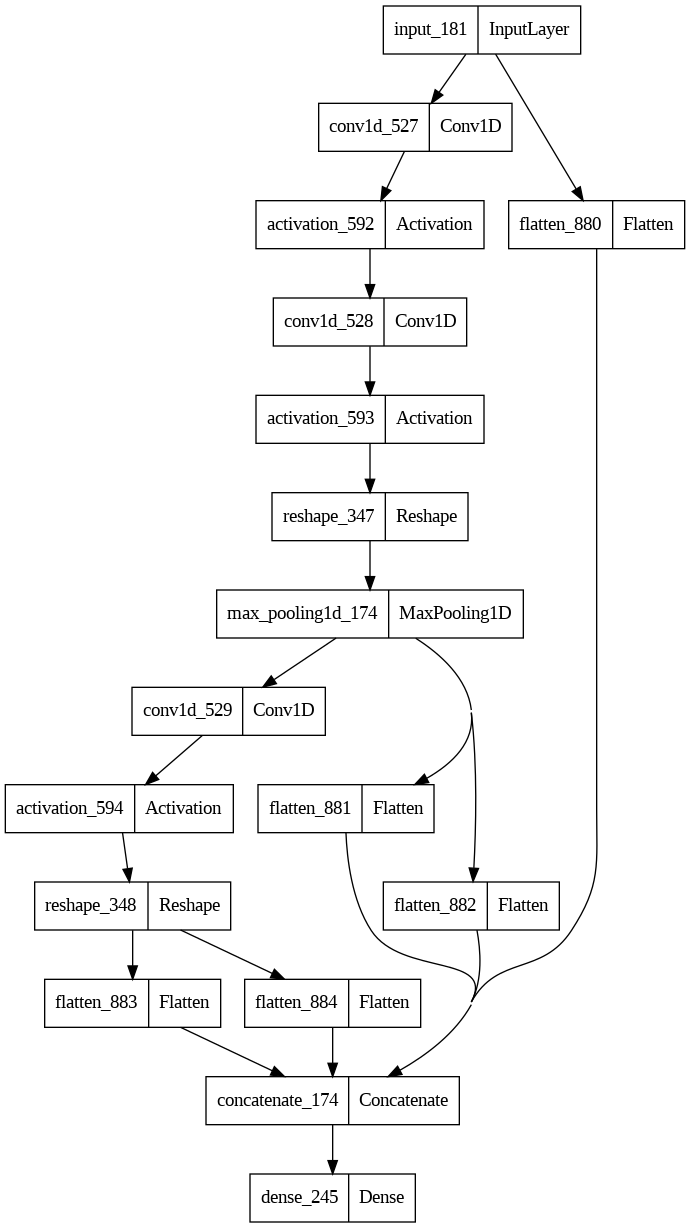

In [28]:
plot_model(model)

In [29]:
#Комипилируем и обучаем
model.compile(optimizer=Adam(lr=1e-4),
                loss='mse')

history = model.fit_generator(trainDataGen,
                    epochs=50,
                    validation_data=testDataGen)

Epoch 1/50


<ipython-input-29-2f2dd0ed534c>:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(trainDataGen,


37/37 [==============================] - 3s 15ms/step - loss: 0.0494 - val_loss: 0.0500
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 0.0142 - val_loss: 0.0315
Epoch 3/50
37/37 [==============================] - 0s 6ms/step - loss: 0.0113 - val_loss: 0.0067
Epoch 4/50
37/37 [==============================] - 0s 6ms/step - loss: 0.0086 - val_loss: 0.0075
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.0091 - val_loss: 0.0108
Epoch 6/50
37/37 [==============================] - 0s 6ms/step - loss: 0.0049 - val_loss: 0.0131
Epoch 7/50
37/37 [==============================] - 0s 6ms/step - loss: 0.0070 - val_loss: 0.0051
Epoch 8/50
37/37 [==============================] - 0s 6ms/step - loss: 0.0046 - val_loss: 0.0052
Epoch 9/50
37/37 [==============================] - 0s 5ms/step - loss: 0.0037 - val_loss: 0.0038
Epoch 10/50
37/37 [==============================] - 0s 6ms/step - loss: 0.0029 - val_loss: 0.0094
Epoch 11/50
37/37 [==========

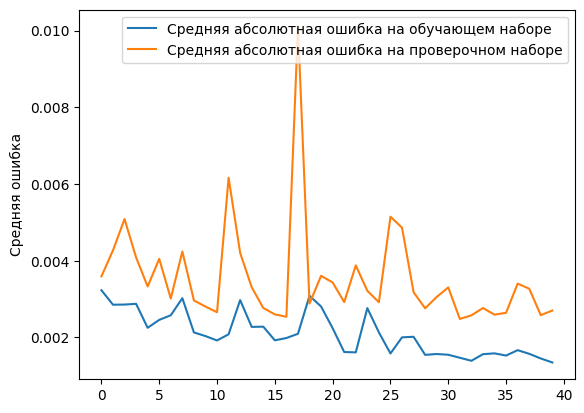

In [30]:
plt.plot(history.history['loss'][10:],
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'][10:],
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

6/6 [==============================] - 0s 2ms/step


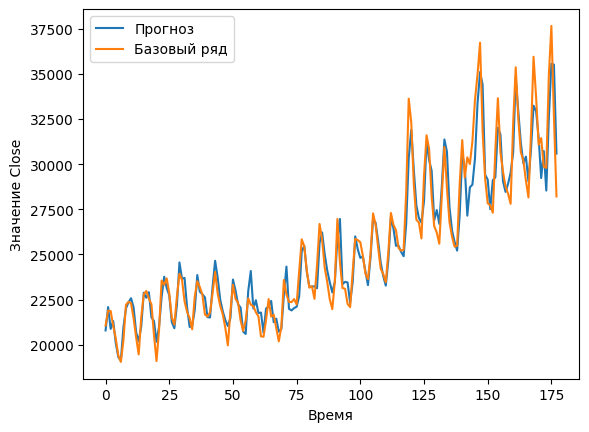

In [31]:
# Прогнозируем данные текущей сетью
currModel = model #Выбираем текущую модель
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], Scaler) #Прогнозируем данные

# Отображаем графики
showPredict(0, 400, 0, predVal, yValUnscaled)

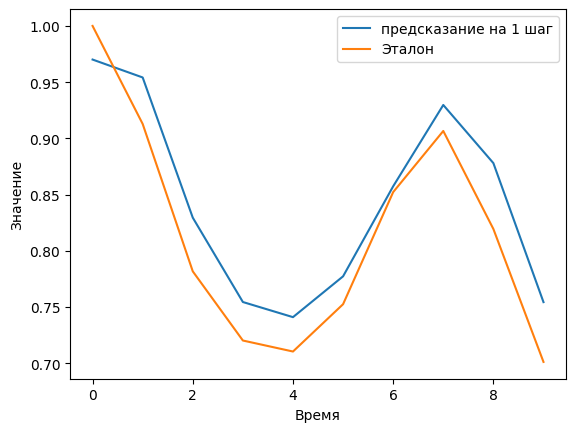

In [32]:
# Отображаем корреляцию
# Используем выходной канал - только open
# Проверяем корреляцию на глубину 60 шагов
autoCorr([0], 10, predVal, yValUnscaled)